### Student Number: 210590034

# Deeper Dive Into The Fantasy Premier League

## Introduction
Eventhough I consider myself a big football fan and a passionate follower of the sport, I never had a chance to play the Fanstasy Premier League. For my first coursework, I wanted to take it as an opportunity to have a better understanding of how the game works, and to have a general idea of what would be a good strategy to follow while building a team.

I will be working under the assuption that the first draft will be set and minimal changes will be made to team throughout the season.

## Data
* Data file from the previous project will be used for further analysis of the incoming players.
* Data from the official Premier League website https://fantasy.premierleague.com/ will be scrapped to get the players' stats for previous seasons.
* Data from https://www.worldfootball.net/ will be scrapped to obtain the players' date of birth

# Objectives
* Compare performance of players last season and the season before
* Compare performance of players in their first season in the Premier League vs. the latest season
* Correlation between the players age and the average number of points
* Compare total number of points vs. average points per game to find players who perform well but do not play as often
* Explore how players who arrived to the Premier League during the winter transfer season did vs. other players to see if it would be necessary to change strategies midseason
* Build a prediction model that would be used as a reference to know which players are predicted to have a good season


In [1]:
#Importing libraries
from bs4 import BeautifulSoup as bs
import requests as req
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqldf
import datetime as dt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

#Supress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Performance of players during season 2021/22 vs. their previous season
Note: The comparison will be made for players returning to the Premier League as well. So for those players, previous season does not neccessarily mean the 2020/21 season

### Get historical data to compare players performance YoY

In [2]:
# Scrape known link to understand the structure of the data
#Scrapping the website
headers = {"User-Agent":"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/102.0.5005.63 Safari/537.36 Edg/102.0.1245.39",
           "Upgrade-Insecure-Requests":"1",
           "Accept":"text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9",
           "Accept-Encoding":"gzip, deflate",
           "Accept-Language": "en-US,en;q=0.9"
          }

url = 'https://fantasy.premierleague.com/api/element-summary/225/'
website = req.get(url, headers = headers).text
content = bs(website, 'html.parser')
site_json = json.loads(content.text)

for item in site_json:
    print(item)

fixtures
history
history_past


In [3]:
hist_stats = pd.DataFrame(site_json['history_past'])
hist_stats

,season_name,element_code,start_cost,end_cost,total_points,minutes,goals_scored,assists,clean_sheets,goals_conceded,...,penalties_missed,yellow_cards,red_cards,saves,bonus,bps,influence,creativity,threat,ict_index
0,2010/11,80954,50,50,27,503,1,1,0,7,...,0,0,0,0,0,0,0.0,0.0,0.0,0.0
1,2020/21,80954,60,57,89,1279,7,4,3,21,...,0,3,0,0,16,341,398.4,409.7,617.0,142.4
2,2021/22,80954,65,63,85,2263,6,2,5,37,...,0,9,0,0,11,351,430.2,558.3,602.0,159.0


In [4]:
# Intitalizing empty dataframe
hist_df = pd.DataFrame()

#For loop to iterate through all links and extract all players historical stats
for x in range(600):
    url = f'https://fantasy.premierleague.com/api/element-summary/{x}/'
    website = req.get(url, headers = headers).text
    content = bs(website, 'html.parser')
    site_json = json.loads(content.text)
    # try/except condition to make sure the data is of the same structure incase a link 
    # with the same name had different data
    try:
        hist_stats = pd.DataFrame(site_json['history_past'])
        hist_df = pd.concat([hist_df,hist_stats])
    except:
        pass

In [5]:
# Check for duplicates
hist_df.duplicated().sum()

0

In [8]:
## Use this import incase extracting data from the website is not possible
# hist_df = pd.read_csv('players_historical_data.csv')

In [6]:
hist_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2126 entries, 0 to 0
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   season_name       2126 non-null   object
 1   element_code      2126 non-null   int64 
 2   start_cost        2126 non-null   int64 
 3   end_cost          2126 non-null   int64 
 4   total_points      2126 non-null   int64 
 5   minutes           2126 non-null   int64 
 6   goals_scored      2126 non-null   int64 
 7   assists           2126 non-null   int64 
 8   clean_sheets      2126 non-null   int64 
 9   goals_conceded    2126 non-null   int64 
 10  own_goals         2126 non-null   int64 
 11  penalties_saved   2126 non-null   int64 
 12  penalties_missed  2126 non-null   int64 
 13  yellow_cards      2126 non-null   int64 
 14  red_cards         2126 non-null   int64 
 15  saves             2126 non-null   int64 
 16  bonus             2126 non-null   int64 
 17  bps              

In [7]:
cols = hist_df.columns.drop('season_name')
hist_df[cols] = hist_df[cols].apply(pd.to_numeric, errors='coerce')
hist_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2126 entries, 0 to 0
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   season_name       2126 non-null   object 
 1   element_code      2126 non-null   int64  
 2   start_cost        2126 non-null   int64  
 3   end_cost          2126 non-null   int64  
 4   total_points      2126 non-null   int64  
 5   minutes           2126 non-null   int64  
 6   goals_scored      2126 non-null   int64  
 7   assists           2126 non-null   int64  
 8   clean_sheets      2126 non-null   int64  
 9   goals_conceded    2126 non-null   int64  
 10  own_goals         2126 non-null   int64  
 11  penalties_saved   2126 non-null   int64  
 12  penalties_missed  2126 non-null   int64  
 13  yellow_cards      2126 non-null   int64  
 14  red_cards         2126 non-null   int64  
 15  saves             2126 non-null   int64  
 16  bonus             2126 non-null   int64  
 17

### Import json file from CW1 and join to historical stats table and get player names

In [9]:
#Read from .json file
with open('plf.json','r') as f:
    site_json = json.load(f)

for item in site_json:
    print(item)

events
game_settings
phases
teams
total_players
elements
element_stats
element_types


In [10]:
#Creating dataset with all player stats from season 2021/2022
stats_df = pd.DataFrame(site_json['elements'])
stats_df

,chance_of_playing_next_round,chance_of_playing_this_round,code,cost_change_event,cost_change_event_fall,cost_change_start,cost_change_start_fall,dreamteam_count,element_type,ep_next,...,threat_rank,threat_rank_type,ict_index_rank,ict_index_rank_type,corners_and_indirect_freekicks_order,corners_and_indirect_freekicks_text,direct_freekicks_order,direct_freekicks_text,penalties_order,penalties_text
0,100.0,100.0,80201,0,0,-5,5,1,1,1.0,...,601,60,443,30,NaN,,NaN,,NaN,
1,0.0,0.0,115918,0,0,0,0,0,1,0.0,...,494,19,545,55,NaN,,NaN,,NaN,
2,0.0,0.0,47431,0,0,-2,2,0,3,0.0,...,733,307,733,307,NaN,,NaN,,NaN,
3,0.0,0.0,54694,0,0,-4,4,0,4,0.0,...,61,27,182,33,NaN,,NaN,,NaN,
4,100.0,100.0,58822,0,0,-3,3,1,2,2.2,...,290,87,232,69,2.0,,3.0,,NaN,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
732,0.0,0.0,428610,0,0,0,0,0,3,0.0,...,640,258,658,259,NaN,,NaN,,NaN,
733,NaN,NaN,510362,0,0,-1,1,0,2,-0.6,...,389,145,424,156,NaN,,NaN,,NaN,
734,0.0,0.0,225000,0,0,0,0,0,2,0.0,...,506,194,556,202,NaN,,NaN,,NaN,
735,0.0,0.0,232351,0,0,0,0,0,3,0.0,...,629,253,648,254,NaN,,NaN,,NaN,


In [11]:
#Create dataset with team details to join to stats dataset and get the team name
teams_df = pd.DataFrame(site_json['teams'])
teams_df

,code,draw,form,id,loss,name,played,points,position,short_name,...,team_division,unavailable,win,strength_overall_home,strength_overall_away,strength_attack_home,strength_attack_away,strength_defence_home,strength_defence_away,pulse_id
0,3,0,None,1,0,Arsenal,0,0,0,ARS,...,None,False,0,1250,1270,1150,1210,1190,1220,1
1,7,0,None,2,0,Aston Villa,0,0,0,AVL,...,None,False,0,1090,1100,1140,1110,1090,1090,2
2,94,0,None,3,0,Brentford,0,0,0,BRE,...,None,False,0,1090,1100,1120,1150,1080,1120,130
3,36,0,None,4,0,Brighton,0,0,0,BHA,...,None,False,0,1100,1090,1160,1160,1100,1120,131
4,90,0,None,5,0,Burnley,0,0,0,BUR,...,None,False,0,1060,1060,1080,1130,1060,1100,43
5,8,0,None,6,0,Chelsea,0,0,0,CHE,...,None,False,0,1290,1280,1300,1300,1250,1290,4
6,31,0,None,7,0,Crystal Palace,0,0,0,CRY,...,None,False,0,1090,1100,1110,1160,1080,1160,6
7,11,0,None,8,0,Everton,0,0,0,EVE,...,None,False,0,1050,1100,1130,1090,1110,1110,7
8,13,0,None,9,0,Leicester,0,0,0,LEI,...,None,False,0,1090,1240,1100,1080,1150,1160,26
9,2,0,None,10,0,Leeds,0,0,0,LEE,...,None,False,0,1070,1070,1080,1070,1100,1100,9


In [12]:
# SQL query to join historical stats dataset with the previous season dataset and the teams dataset to get
# player names and team names

query = """
SELECT first_name||' '||second_name AS player_name, name AS team, hist_df.*
FROM hist_df
LEFT JOIN stats_df ON hist_df.element_code = stats_df.code
LEFT JOIN teams_df ON stats_df.team_code = teams_df.code
"""

comp_hist = sqldf.run(query)
comp_hist = comp_hist.drop(columns = ['index'])
comp_hist

,player_name,team,season_name,element_code,start_cost,end_cost,total_points,minutes,goals_scored,assists,...,penalties_missed,yellow_cards,red_cards,saves,bonus,bps,influence,creativity,threat,ict_index
0,Cédric Soares,Arsenal,2015/16,58822,50,47,86,1965,0,2,...,0,3,0,0,7,506,0.0,0.0,0.0,0.0
1,Cédric Soares,Arsenal,2016/17,58822,50,49,102,2515,0,3,...,0,7,0,0,11,584,591.0,648.9,155.0,139.6
2,Cédric Soares,Arsenal,2017/18,58822,50,47,85,2794,0,3,...,0,3,0,0,2,481,507.0,455.6,159.0,112.3
3,Cédric Soares,Arsenal,2018/19,58822,45,42,52,1493,1,2,...,0,4,0,0,7,273,309.0,226.5,103.0,63.9
4,Cédric Soares,Arsenal,2019/20,58822,50,48,61,1553,1,1,...,0,1,0,0,3,286,349.0,218.9,118.0,68.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2121,Mathias Jorgensen,Brentford,2018/19,48760,45,44,67,2147,3,1,...,0,6,0,0,4,402,544.2,103.7,169.0,81.9
2122,Mathias Jorgensen,Brentford,2021/22,48760,45,45,18,516,1,0,...,0,2,0,0,0,84,108.6,44.9,57.0,21.1
2123,Evan Ferguson,Brighton,2021/22,487117,45,45,1,22,0,0,...,0,0,0,0,0,4,2.0,4.8,2.0,0.9
2124,None,None,2019/20,461017,45,45,0,0,0,0,...,0,0,0,0,0,0,0.0,0.0,0.0,0.0


In [13]:
# Add rank column to find the previous 2 seasons for all players
comp_hist['rank'] = comp_hist.groupby('player_name')['season_name'].rank(ascending=False).astype('int32')
comp_hist

,player_name,team,season_name,element_code,start_cost,end_cost,total_points,minutes,goals_scored,assists,...,yellow_cards,red_cards,saves,bonus,bps,influence,creativity,threat,ict_index,rank
0,Cédric Soares,Arsenal,2015/16,58822,50,47,86,1965,0,2,...,3,0,0,7,506,0.0,0.0,0.0,0.0,7
1,Cédric Soares,Arsenal,2016/17,58822,50,49,102,2515,0,3,...,7,0,0,11,584,591.0,648.9,155.0,139.6,6
2,Cédric Soares,Arsenal,2017/18,58822,50,47,85,2794,0,3,...,3,0,0,2,481,507.0,455.6,159.0,112.3,5
3,Cédric Soares,Arsenal,2018/19,58822,45,42,52,1493,1,2,...,4,0,0,7,273,309.0,226.5,103.0,63.9,4
4,Cédric Soares,Arsenal,2019/20,58822,50,48,61,1553,1,1,...,1,0,0,3,286,349.0,218.9,118.0,68.7,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2121,Mathias Jorgensen,Brentford,2018/19,48760,45,44,67,2147,3,1,...,6,0,0,4,402,544.2,103.7,169.0,81.9,2
2122,Mathias Jorgensen,Brentford,2021/22,48760,45,45,18,516,1,0,...,2,0,0,0,84,108.6,44.9,57.0,21.1,1
2123,Evan Ferguson,Brighton,2021/22,487117,45,45,1,22,0,0,...,0,0,0,0,4,2.0,4.8,2.0,0.9,1
2124,None,None,2019/20,461017,45,45,0,0,0,0,...,0,0,0,0,0,0.0,0.0,0.0,0.0,38


In [14]:
# Keep only last 2 seasons for each player
comp_hist = comp_hist[comp_hist['rank'] <= 2]

# Shift season points 
comp_hist['previous_season_points'] = comp_hist.groupby(['player_name'])['total_points'].shift(1)
comp_hist = comp_hist.dropna()
comp_hist

<ipython-input-14-48e92086c1db>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comp_hist['previous_season_points'] = comp_hist.groupby(['player_name'])['total_points'].shift(1)


,player_name,team,season_name,element_code,start_cost,end_cost,total_points,minutes,goals_scored,assists,...,red_cards,saves,bonus,bps,influence,creativity,threat,ict_index,rank,previous_season_points
6,Cédric Soares,Arsenal,2021/22,58822,45,42,48,1481,1,1,...,0,0,3,292,318.4,327.1,111.0,75.8,1,28.0
10,Bernd Leno,Arsenal,2021/22,80201,50,45,10,360,0,0,...,0,10,0,69,85.0,0.0,0.0,8.5,1,131.0
16,Granit Xhaka,Arsenal,2021/22,84450,50,48,60,2327,1,2,...,1,0,3,334,395.4,522.9,262.0,118.2,1,70.0
23,Mohamed Naser El Sayed Elneny,Arsenal,2021/22,153256,45,44,27,801,0,2,...,0,0,0,156,163.2,131.5,49.0,34.4,1,50.0
29,Rob Holding,Arsenal,2021/22,156074,45,41,29,840,1,0,...,1,0,2,152,253.0,8.6,49.0,31.1,1,105.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2085,Conor Coventry,West Ham,2021/22,222017,45,45,0,0,0,0,...,0,0,0,0,0.0,0.0,0.0,0.0,1,0.0
2087,Hugo Bueno,Wolves,2021/22,490721,40,40,0,0,0,0,...,0,0,0,0,0.0,0.0,0.0,0.0,1,0.0
2100,Darren Randolph,West Ham,2021/22,32259,45,43,0,0,0,0,...,0,0,0,0,0.0,0.0,0.0,0.0,1,10.0
2118,Cheikhou Kouyaté,Crystal Palace,2021/22,55037,45,45,77,1970,0,1,...,0,0,5,395,315.0,85.8,41.0,44.3,1,82.0


In [15]:
# Calculating the point difference between the 2021/22 season and the season before to compare
query2="""
SELECT player_name, team, total_points, previous_season_points, total_points-previous_season_points AS point_difference
FROM comp_hist
"""

point_diff = sqldf.run(query2)
point_diff

,player_name,team,total_points,previous_season_points,point_difference
0,Cédric Soares,Arsenal,48,28.0,20.0
1,Bernd Leno,Arsenal,10,131.0,-121.0
2,Granit Xhaka,Arsenal,60,70.0,-10.0
3,Mohamed Naser El Sayed Elneny,Arsenal,27,50.0,-23.0
4,Rob Holding,Arsenal,29,105.0,-76.0
...,...,...,...,...,...
356,Conor Coventry,West Ham,0,0.0,0.0
357,Hugo Bueno,Wolves,0,0.0,0.0
358,Darren Randolph,West Ham,0,10.0,-10.0
359,Cheikhou Kouyaté,Crystal Palace,77,82.0,-5.0


In [16]:
# Comparing the perfromance of the players who scored 0 points in the 2021/22 season compared to the previous season
point_diff[point_diff['total_points'] == 0]

,player_name,team,total_points,previous_season_points,point_difference
18,Lucas Torreira,Arsenal,0,0.0,0.0
20,William Saliba,Arsenal,0,0.0,0.0
45,Frédéric Guilbert,Aston Villa,0,0.0,0.0
89,Ethan Ampadu,Chelsea,0,44.0,-44.0
130,Niels Nkounkou,Everton,0,2.0,-2.0
132,Nathaniel Chalobah,Watford,0,36.0,-36.0
213,Luke Mbete,Man City,0,0.0,0.0
234,Andreas Pereira,Man Utd,0,0.0,0.0
235,Tom Heaton,Man Utd,0,0.0,0.0
263,Dean Henderson,Man Utd,0,44.0,-44.0


In [17]:
# Comparing the perfromance of the 10 players who scored the most points in the 2021/22 season
# compared to the previous season
point_diff.sort_values('total_points', ascending = False).head(10)

,player_name,team,total_points,previous_season_points,point_difference
184,Mohamed Salah,Liverpool,265,231.0,34.0
287,Heung-Min Son,Spurs,258,228.0,30.0
186,Trent Alexander-Arnold,Liverpool,208,160.0,48.0
316,Jarrod Bowen,West Ham,206,141.0,65.0
202,João Pedro Cavaco Cancelo,Man City,201,138.0,63.0
197,Kevin De Bruyne,Man City,196,141.0,55.0
286,Harry Kane,Spurs,192,242.0,-50.0
185,Andrew Robertson,Liverpool,186,161.0,25.0
181,Virgil van Dijk,Liverpool,183,15.0,168.0
166,James Maddison,Leicester,181,133.0,48.0


In [18]:
# Comparing the perfromance of the players who scored 0 points in the previous season compared to the 2021/22 season
point_diff[point_diff['previous_season_points'] == 0]

,player_name,team,total_points,previous_season_points,point_difference
18,Lucas Torreira,Arsenal,0,0.0,0.0
20,William Saliba,Arsenal,0,0.0,0.0
41,Tim Iroegbunam,Aston Villa,4,0.0,4.0
45,Frédéric Guilbert,Aston Villa,0,0.0,0.0
50,Jason Steele,Brighton,2,0.0,2.0
53,Shane Duffy,Brighton,48,0.0,48.0
65,Moisés Caicedo,Brighton,27,0.0,27.0
77,Robert Kenedy Nunes do Nascimento,Chelsea,4,0.0,4.0
80,Trevoh Chalobah,Chelsea,99,0.0,99.0
104,Marc Guéhi,Crystal Palace,123,0.0,123.0


In [19]:
# Comparing the perfromance of the 10 players who scored the most points in the previous season
# compared to the 2021/22 season
point_diff.sort_values('previous_season_points', ascending = False).head(10)

,player_name,team,total_points,previous_season_points,point_difference
222,Bruno Miguel Borges Fernandes,Man Utd,151,244.0,-93.0
286,Harry Kane,Spurs,192,242.0,-50.0
184,Mohamed Salah,Liverpool,265,231.0,34.0
287,Heung-Min Son,Spurs,258,228.0,30.0
216,Cristiano Ronaldo dos Santos Aveiro,Man Utd,159,206.0,-47.0
139,Patrick Bamford,Leeds,28,194.0,-166.0
160,Jamie Vardy,Leicester,133,187.0,-54.0
24,Emiliano Martínez,Aston Villa,129,186.0,-57.0
224,Marcus Rashford,Man Utd,63,174.0,-111.0
138,Stuart Dallas,Leeds,80,171.0,-91.0


In [20]:
# Players that saw the biggest improvement
point_diff.sort_values('point_difference', ascending = False).head(10)

,player_name,team,total_points,previous_season_points,point_difference
181,Virgil van Dijk,Liverpool,183,15.0,168.0
47,Ivan Toney,Brentford,139,2.0,137.0
177,Joel Matip,Liverpool,170,42.0,128.0
104,Marc Guéhi,Crystal Palace,123,0.0,123.0
123,Demarai Gray,Everton,106,1.0,105.0
205,Aymeric Laporte,Man City,160,58.0,102.0
80,Trevoh Chalobah,Chelsea,99,0.0,99.0
128,Anthony Gordon,Everton,100,3.0,97.0
88,Armando Broja,Southampton,92,1.0,91.0
6,Martin Ødegaard,Arsenal,131,40.0,91.0


In [21]:
# Players who saw the biggest performace drop
point_diff.sort_values('point_difference', ascending = True).head(10)

,player_name,team,total_points,previous_season_points,point_difference
139,Patrick Bamford,Leeds,28,194.0,-166.0
323,Alphonse Areola,West Ham,2,124.0,-122.0
27,Bertrand Traoré,Aston Villa,13,135.0,-122.0
1,Bernd Leno,Arsenal,10,131.0,-121.0
111,Salomón Rondón,Everton,30,148.0,-118.0
224,Marcus Rashford,Man Utd,63,174.0,-111.0
341,Ben Davies,Liverpool,0,105.0,-105.0
229,Aaron Wan-Bissaka,Man Utd,41,144.0,-103.0
334,Pedro Lomba Neto,Wolves,22,124.0,-102.0
125,Dominic Calvert-Lewin,Everton,64,165.0,-101.0


As can be seen from the tables above, with the exception of very few players, the number of points aquired does not vary much. This will be helpful when choosing the starting draft as one can expect the players that performed well in a season to perform at the same level next season

## Performance of players in their first season in the Premier League vs. the latest season

In [22]:
# Recreating the historical players stats table to rank the season in ascending order
comp_hist2 = sqldf.run(query)
comp_hist2['rank2'] = comp_hist2.groupby('player_name')['season_name'].rank(ascending=True).astype('int32')
comp_hist2

,player_name,team,index,season_name,element_code,start_cost,end_cost,total_points,minutes,goals_scored,...,yellow_cards,red_cards,saves,bonus,bps,influence,creativity,threat,ict_index,rank2
0,Cédric Soares,Arsenal,0,2015/16,58822,50,47,86,1965,0,...,3,0,0,7,506,0.0,0.0,0.0,0.0,1
1,Cédric Soares,Arsenal,1,2016/17,58822,50,49,102,2515,0,...,7,0,0,11,584,591.0,648.9,155.0,139.6,2
2,Cédric Soares,Arsenal,2,2017/18,58822,50,47,85,2794,0,...,3,0,0,2,481,507.0,455.6,159.0,112.3,3
3,Cédric Soares,Arsenal,3,2018/19,58822,45,42,52,1493,1,...,4,0,0,7,273,309.0,226.5,103.0,63.9,4
4,Cédric Soares,Arsenal,4,2019/20,58822,50,48,61,1553,1,...,1,0,0,3,286,349.0,218.9,118.0,68.7,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2121,Mathias Jorgensen,Brentford,1,2018/19,48760,45,44,67,2147,3,...,6,0,0,4,402,544.2,103.7,169.0,81.9,2
2122,Mathias Jorgensen,Brentford,2,2021/22,48760,45,45,18,516,1,...,2,0,0,0,84,108.6,44.9,57.0,21.1,3
2123,Evan Ferguson,Brighton,0,2021/22,487117,45,45,1,22,0,...,0,0,0,0,4,2.0,4.8,2.0,0.9,1
2124,None,None,0,2019/20,461017,45,45,0,0,0,...,0,0,0,0,0,0.0,0.0,0.0,0.0,109


In [23]:
# Getting the players' first season using the rank2 column
first_season = comp_hist2.loc[comp_hist2.groupby('player_name')['rank2'].idxmin()]
first_season

,player_name,team,index,season_name,element_code,start_cost,end_cost,total_points,minutes,goals_scored,...,yellow_cards,red_cards,saves,bonus,bps,influence,creativity,threat,ict_index,rank2
1824,Aaron Cresswell,West Ham,0,2014/15,55459,55,56,129,3420,2,...,5,0,0,13,593,0.0,0.0,0.0,0.0,1
57,Aaron Ramsdale,Arsenal,0,2016/17,225321,40,40,0,0,0,...,0,0,0,0,0,0.0,0.0,0.0,0.0,1
1320,Aaron Wan-Bissaka,Man Utd,0,2016/17,214590,45,45,0,0,0,...,0,0,0,0,0,0.0,0.0,0.0,0.0,1
658,Abdoulaye Doucouré,Everton,0,2016/17,121599,50,46,38,1352,1,...,4,0,0,0,226,179.4,178.2,254.0,61.1,1
1626,Adam Armstrong,Southampton,0,2013/14,155511,45,45,4,34,0,...,0,0,0,0,4,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248,Yoane Wissa,Brentford,0,2021/22,216646,60,57,92,1268,7,...,0,0,0,6,277,348.0,133.1,402.0,87.6,1
935,Youri Tielemans,Leicester,0,2018/19,166989,60,60,63,1087,3,...,2,0,0,6,267,299.0,269.7,249.0,81.8,1
1782,Yves Bissouma,Brighton,0,2018/19,227127,50,46,43,1764,0,...,5,0,0,0,170,253.4,213.0,201.0,66.8,1
1203,Zack Steffen,Man City,0,2020/21,164484,45,44,2,90,0,...,0,0,1,0,8,9.6,0.0,0.0,1.0,1


In [24]:
# Getting the players' last season using the rank2 column
# And filtering out players who spent only one season in the Premier League
last_season = comp_hist2.loc[comp_hist2.groupby('player_name')['rank2'].idxmax()]
last_season = last_season[last_season['rank2'] > 1]
last_season

,player_name,team,index,season_name,element_code,start_cost,end_cost,total_points,minutes,goals_scored,...,yellow_cards,red_cards,saves,bonus,bps,influence,creativity,threat,ict_index,rank2
1831,Aaron Cresswell,West Ham,7,2021/22,55459,55,54,115,2726,2,...,3,0,0,17,578,589.2,545.7,187.0,132.4,8
61,Aaron Ramsdale,Arsenal,4,2021/22,225321,45,51,135,3060,0,...,1,0,90,14,641,690.2,1.0,0.0,69.0,5
1325,Aaron Wan-Bissaka,Man Utd,5,2021/22,214590,55,51,41,1793,0,...,2,0,0,3,329,371.8,237.0,123.0,73.3,6
663,Abdoulaye Doucouré,Everton,5,2021/22,121599,55,53,90,2536,2,...,6,0,0,8,387,481.8,285.8,441.0,121.1,6
1629,Adam Armstrong,Southampton,3,2021/22,155511,60,57,57,1409,2,...,1,0,0,3,150,179.2,180.2,575.0,92.7,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
677,Yerry Mina,Everton,3,2021/22,164511,50,49,24,844,0,...,3,0,0,0,133,164.8,18.2,66.0,24.6,4
938,Youri Tielemans,Leicester,3,2021/22,166989,65,64,120,2629,6,...,3,0,0,14,532,723.8,578.9,460.0,175.8,4
1785,Yves Bissouma,Brighton,3,2021/22,227127,45,44,66,2110,1,...,10,0,0,9,351,429.2,169.3,126.0,72.4,4
1204,Zack Steffen,Man City,1,2021/22,164484,45,44,7,90,0,...,0,0,2,1,29,23.0,0.0,0.0,2.3,2


In [25]:
# Average points earned by players on their first season
first_season['total_points'].mean()

46.70480549199085

In [26]:
# Average points earned by players during their latest season
last_season['total_points'].mean()

65.98337950138504

In [27]:
# Table of players with the highest points on their first season
first_season[['player_name', 'team', 'season_name', 'total_points']].sort_values('total_points', ascending = False).head(10)

,player_name,team,season_name,total_points
1238,Cristiano Ronaldo dos Santos Aveiro,Man Utd,2006/07,244
1917,Raúl Jiménez,Wolves,2018/19,181
1052,Alisson Ramses Becker,Liverpool,2018/19,176
805,Stuart Dallas,Leeds,2020/21,171
155,Ollie Watkins,Aston Villa,2020/21,168
636,Bamidele Alli,Everton,2015/16,166
485,Christian Benteke,Crystal Palace,2012/13,166
289,Pascal Groß,Brighton,2017/18,164
1554,Dean Henderson,Man Utd,2019/20,160
825,Jack Harrison,Leeds,2020/21,160


As can be seen from the tables above, players have a lower average points during their first season.
However, Cristiano Ronaldo seems to have had an exceptionally good first season

## Correlation between the players age and the average number of points

In [28]:
# Extracting player age data from different source
age_df = pd.DataFrame(columns=['player_name', 'team', 'born'])
seasons_list = ['2020-2021', '2021-2022']

# For loop to iterate through website pages
for y in seasons_list:
    for x in range(20):
        url = f'https://www.worldfootball.net/players_list/eng-premier-league-{y}/nach-alter/{x}/'
        data = req.get(url).text
        soup = bs(data, 'html.parser')
        tables = soup.find_all('table')
        table = soup.find('table', class_='standard_tabelle')

        for row in table.find_all('tr'):
            columns = row.find_all('td')
            
            # try/except condition to make sure the data is of the same structure
            try:
                if columns != []:
                    player_name = columns[0].text
                    team = columns[2].text
                    born = columns[3].text


                    age_df = age_df.append({'player_name': player_name,  'team': team, 'born': born}, ignore_index=True)
            except:
                pass

In [29]:
## Use this import incase extracting data from the website is not possible
# age_df = pd.read_csv('players_birth_date.csv')

In [30]:
age_df

,player_name,team,born
0,Alfie Devine,Tottenham Hotspur,01/08/2004
1,Thierry Small,Everton FC,01/08/2004
2,Frankie Ealing,Aston Villa,14/07/2004
3,Oliwier Zych,Aston Villa,28/06/2004
4,Dane Scarlett,Tottenham Hotspur,24/03/2004
...,...,...,...
1318,Michael McGovern,Norwich City,12/07/1984
1319,Andy Lonergan,Everton FC,19/10/1983
1320,Ben Foster,Watford FC,03/04/1983
1321,Lee Grant,Manchester United,27/01/1983


In [31]:
age_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1323 entries, 0 to 1322
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   player_name  1323 non-null   object
 1   team         1323 non-null   object
 2   born         1323 non-null   object
dtypes: object(3)
memory usage: 31.1+ KB


In [32]:
# Removing duplicate entries
age_df.drop_duplicates(inplace = True)
age_df.duplicated().sum()

0

In [33]:
# Changing born column to date formate
age_df['born']= pd.to_datetime(age_df['born'], format="%d/%m/%Y")
age_df

,player_name,team,born
0,Alfie Devine,Tottenham Hotspur,2004-08-01
1,Thierry Small,Everton FC,2004-08-01
2,Frankie Ealing,Aston Villa,2004-07-14
3,Oliwier Zych,Aston Villa,2004-06-28
4,Dane Scarlett,Tottenham Hotspur,2004-03-24
...,...,...,...
1315,Cristiano Ronaldo,Manchester United,1985-02-05
1318,Michael McGovern,Norwich City,1984-07-12
1319,Andy Lonergan,Everton FC,1983-10-19
1320,Ben Foster,Watford FC,1983-04-03


In [34]:
# Calculating age at the time of the season end
age_df['age_2022'] = round((pd.to_datetime('2022-06-01', format="%Y-%m-%d") - age_df['born']).dt.days/365)
age_df

,player_name,team,born,age_2022
0,Alfie Devine,Tottenham Hotspur,2004-08-01,18.0
1,Thierry Small,Everton FC,2004-08-01,18.0
2,Frankie Ealing,Aston Villa,2004-07-14,18.0
3,Oliwier Zych,Aston Villa,2004-06-28,18.0
4,Dane Scarlett,Tottenham Hotspur,2004-03-24,18.0
...,...,...,...,...
1315,Cristiano Ronaldo,Manchester United,1985-02-05,37.0
1318,Michael McGovern,Norwich City,1984-07-12,38.0
1319,Andy Lonergan,Everton FC,1983-10-19,39.0
1320,Ben Foster,Watford FC,1983-04-03,39.0


In [35]:
# Import cleaned season 2021/2022 stats (previous coursework)
season_df = pd.read_csv('season_data.csv')
season_df.info

<bound method DataFrame.info of      dreamteam_count  now_cost  points_per_game  selected_by_percent  \
0                  1       4.5              2.5                  0.8   
1                  0       9.6              3.1                  1.2   
2                  1       4.2              2.3                  0.4   
3                  1       8.1              3.0                  3.1   
4                  0       4.8              2.2                  0.4   
..               ...       ...              ...                  ...   
532                0       4.4              1.8                  0.1   
533                0       4.4              1.0                  0.2   
534                1       5.4              2.7                  3.4   
535                0       4.4              1.5                  0.0   
536                0       5.5              2.5                  0.0   

     total_points  transfers_in  transfers_out  minutes  goals_scored  \
0              10         8097

In [36]:
season_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 537 entries, 0 to 536
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   dreamteam_count      537 non-null    int64  
 1   now_cost             537 non-null    float64
 2   points_per_game      537 non-null    float64
 3   selected_by_percent  537 non-null    float64
 4   total_points         537 non-null    int64  
 5   transfers_in         537 non-null    int64  
 6   transfers_out        537 non-null    int64  
 7   minutes              537 non-null    int64  
 8   goals_scored         537 non-null    int64  
 9   assists              537 non-null    int64  
 10  clean_sheets         537 non-null    int64  
 11  goals_conceded       537 non-null    int64  
 12  own_goals            537 non-null    int64  
 13  penalties_saved      537 non-null    int64  
 14  penalties_missed     537 non-null    int64  
 15  yellow_cards         537 non-null    int

In [37]:
# Adding age column to the season stats dataset
query3 = """
SELECT season_df.*, age_2022
FROM season_df
LEFT JOIN age_df ON LOWER(season_df.player_name) = LOWER(age_df.player_name)
"""

season_df = sqldf.run(query3)
season_df = season_df.drop(columns = ['index'])
season_df

,dreamteam_count,now_cost,points_per_game,selected_by_percent,total_points,transfers_in,transfers_out,minutes,goals_scored,assists,...,bonus,bps,influence,creativity,threat,ict_index,team,position,player_name,age_2022
0,1,4.5,2.5,0.8,10,80974,205566,360,0,0,...,0,69,85.0,0.0,0.0,8.5,Arsenal,Goalkeeper,Bernd Leno,30.0
1,0,9.6,3.1,1.2,44,742898,900060,1036,4,1,...,7,131,217.6,132.4,582.0,92.9,Arsenal,Forward,Pierre-Emerick Aubameyang,33.0
2,1,4.2,2.3,0.4,48,66997,55154,1481,1,1,...,3,292,318.4,327.1,111.0,75.8,Arsenal,Defender,Cédric Soares,NaN
3,1,8.1,3.0,3.1,90,1729889,1688857,1773,4,8,...,3,295,376.6,386.2,731.0,148.5,Arsenal,Forward,Alexandre Lacazette,31.0
4,0,4.8,2.2,0.4,60,49300,97620,2327,1,2,...,3,334,395.4,522.9,262.0,118.2,Arsenal,Midfielder,Granit Xhaka,30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567,0,4.4,1.8,0.1,7,12082,11827,179,0,0,...,0,32,17.0,32.0,2.0,5.1,Wolves,Midfielder,Luke Cundle,20.0
568,0,4.4,1.0,0.2,1,40835,37967,12,0,0,...,0,5,2.0,1.7,2.0,0.6,Wolves,Midfielder,Chem Campbell,19.0
569,1,5.4,2.7,3.4,81,2119461,1898820,1811,5,1,...,11,288,322.2,268.3,481.0,106.7,Wolves,Forward,Hee-Chan Hwang,26.0
570,0,4.4,1.5,0.0,6,696,558,360,0,0,...,0,52,87.0,4.5,28.0,12.0,Wolves,Defender,Toti António Gomes,NaN


In [38]:
# Checking the number of players who were missed in the new table
season_df['age_2022'].isna().sum()

151

In [39]:
# Creating a table with the players that have null values for the age column and arranging them by total points
query4 = """
SELECT player_name, total_points
FROM season_df
WHERE age_2022 IS NULL
ORDER BY 2 DESC
"""

sqldf.run(query4).head(10)

,player_name,total_points
0,Mohamed Salah,265
1,João Pedro Cavaco Cancelo,201
2,Alisson Ramses Becker,176
3,Diogo Jota,175
4,Cristiano Ronaldo dos Santos Aveiro,159
5,Ederson Santana de Moraes,155
6,Bernardo Mota Veiga de Carvalho e Silva,155
7,Bruno Miguel Borges Fernandes,151
8,Matthew Cash,147
9,Gabriel Magalhães,146


Due to the different naming convention by the 2 different sources, not all players age was joined. Including the player with the highest points, Mohamed Salah.

For the purpose of this project, I will not be diving deeper into fixing this issue. As we only need to see if there is a correlation between the age of a player and the points they achieve.

<AxesSubplot:xlabel='age_2022', ylabel='total_points'>

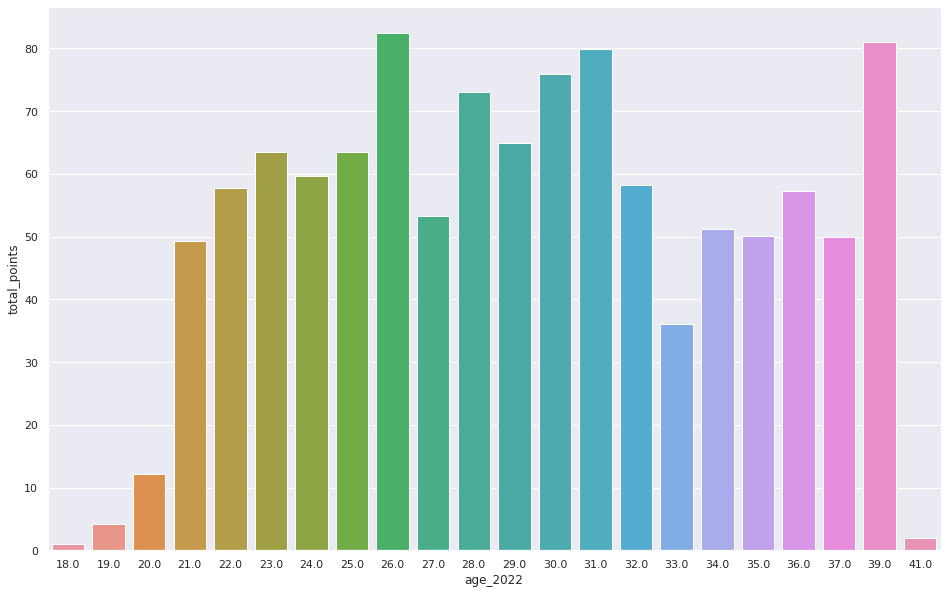

In [40]:
# Plotting the age against the average number of points
sns.set(rc={'figure.figsize':(16,10)})
sns.barplot('age_2022', 'total_points', data=season_df, ci=False)

In [41]:
# Breakdown of the above plot
season_df.groupby('age_2022')['total_points'].mean()

age_2022
18.0     1.000000
19.0     4.222222
20.0    12.208333
21.0    49.333333
22.0    57.680000
23.0    63.565217
24.0    59.739130
25.0    63.512821
26.0    82.466667
27.0    53.228571
28.0    73.115385
29.0    64.861111
30.0    75.906250
31.0    79.961538
32.0    58.238095
33.0    36.080000
34.0    51.166667
35.0    50.181818
36.0    57.333333
37.0    50.000000
39.0    81.000000
41.0     2.000000
Name: total_points, dtype: float64

From the above we can see that the age range with the highest point average is between 23 and 31.

## Compare total number of points vs. average points per game to find players who perform well but do not play as often

In [42]:
# Create dataframe that only contains the required columns and sort descendingly according 
# to player average point per game
query5= """
SELECT player_name, points_per_game, total_points
FROM season_df
ORDER BY 2 DESC
"""

sqldf.run(query5).head(20)

,player_name,points_per_game,total_points
0,Benjamin Chilwell,7.9,55
1,Mohamed Salah,7.6,265
2,Heung-Min Son,7.4,258
3,Zack Steffen,7.0,7
4,Trent Alexander-Arnold,6.5,208
5,Kevin De Bruyne,6.5,196
6,Ferran Torres,6.5,26
7,Andrew Robertson,6.4,186
8,Jarrod Bowen,5.7,206
9,João Pedro Cavaco Cancelo,5.6,201


The data above proves the fact that even though the players with the highest total point might be the most consitent players, players who do not play as often can still get higher points in a given round. We can see that the player with the highest average points per game, Benjamin Chilwell, only had 55 points total. But, had a higher point average than Mohamed Salah.

## Explore how players who arrived to the Premier League during the winter transfer season did vs. other players to see if it would be necessary to change strategies midseason

In [43]:
# Import data manually extracted from the official Premier League website for the incoming players
jan_df = pd.read_csv('premier_league_january_incoming_transfers.csv')
jan_df

,player_name,from_team,to_team
0,Lino Sousa,West Brom,Arsenal
1,Auston Trusty,Colorado Rapids,Arsenal
2,Philippe Coutinho Correia,Barcelona,Aston Villa
3,Lucas Digne,Everton,Aston Villa
4,Robin Olsen,Roma,Aston Villa
5,Calum Chambers,Arsenal,Aston Villa
6,Jonas Lossl,Midtjylland,Brentford
7,Christian Eriksen,Unattached,Brentford
8,Hans Mpongo,Needham Market,Brentford
9,Deji Sotona,Nice,Brentford


In [44]:
# Join table of incoming players with stats table to see how well the incoming players performed
query6 = """
SELECT DISTINCT jan_df.player_name, position, team, points_per_game, total_points
FROM jan_df
INNER JOIN season_df ON jan_df.player_name = season_df.player_name
ORDER BY points_per_game DESC
"""

jan_players_perf = sqldf.run(query6)
jan_players_perf

,player_name,position,team,points_per_game,total_points
0,Dejan Kulusevski,Midfielder,Spurs,5.5,99
1,Kieran Trippier,Defender,Newcastle,4.7,28
2,Philippe Coutinho Correia,Midfielder,Aston Villa,4.4,83
3,Christian Eriksen,Midfielder,Brentford,3.9,43
4,Calum Chambers,Defender,Aston Villa,3.2,42
5,Vitalii Mykolenko,Defender,Everton,3.2,42
6,Dan Burn,Defender,Newcastle,3.2,92
7,Matt Targett,Defender,Newcastle,3.1,101
8,Rodrigo Bentancur,Midfielder,Spurs,3.1,52
9,Lucas Digne,Defender,Aston Villa,2.9,83


List of stats became shorter due to the fact that most players that were brought in were immediately sent back out on loan deals and such

In [45]:
# Deine funtion to find the best players that came in January based on their position and compare them to 
# their counterparts who were already present in the league
def top_5_points_per_game(position, dataset):
    top = dataset[dataset['position'] == position][['player_name', 'position', 'team', 'points_per_game', 'total_points']].sort_values('points_per_game', ascending = False).head(5)
    print(top)

In [46]:
top_5_points_per_game('Goalkeeper', jan_players_perf)

        player_name    position         team  points_per_game  total_points
18      Robin Olsen  Goalkeeper  Aston Villa              1.0             1
19  Willy Caballero  Goalkeeper  Southampton              1.0             2


In [47]:
top_5_points_per_game('Goalkeeper', season_df)

                   player_name    position       team  points_per_game  \
330               Zack Steffen  Goalkeeper   Man City              7.0   
297      Alisson Ramses Becker  Goalkeeper  Liverpool              4.9   
146          Kepa Arrizabalaga  Goalkeeper    Chelsea              4.8   
211              Asmir Begović  Goalkeeper    Everton              4.3   
327  Ederson Santana de Moraes  Goalkeeper   Man City              4.2   

     total_points  
330             7  
297           176  
146            19  
211            13  
327           155  


In [48]:
top_5_points_per_game('Defender', jan_players_perf)

         player_name  position         team  points_per_game  total_points
1    Kieran Trippier  Defender    Newcastle              4.7            28
4     Calum Chambers  Defender  Aston Villa              3.2            42
5  Vitalii Mykolenko  Defender      Everton              3.2            42
6           Dan Burn  Defender    Newcastle              3.2            92
7       Matt Targett  Defender    Newcastle              3.1           101


In [49]:
top_5_points_per_game('Defender', season_df)

                   player_name  position       team  points_per_game  \
153          Benjamin Chilwell  Defender    Chelsea              7.9   
304     Trent Alexander-Arnold  Defender  Liverpool              6.5   
300           Andrew Robertson  Defender  Liverpool              6.4   
326  João Pedro Cavaco Cancelo  Defender   Man City              5.6   
291                 Joel Matip  Defender  Liverpool              5.5   

     total_points  
153            55  
304           208  
300           186  
326           201  
291           170  


In [50]:
top_5_points_per_game('Midfielder', jan_players_perf)

                  player_name    position         team  points_per_game  \
0            Dejan Kulusevski  Midfielder        Spurs              5.5   
2   Philippe Coutinho Correia  Midfielder  Aston Villa              4.4   
3           Christian Eriksen  Midfielder    Brentford              3.9   
8           Rodrigo Bentancur  Midfielder        Spurs              3.1   
13          Donny van de Beek  Midfielder      Everton              2.1   

    total_points  
0             99  
2             83  
3             43  
8             52  
13            31  


In [51]:
top_5_points_per_game('Midfielder', season_df)

         player_name    position       team  points_per_game  total_points
299    Mohamed Salah  Midfielder  Liverpool              7.6           265
464    Heung-Min Son  Midfielder      Spurs              7.4           258
321  Kevin De Bruyne  Midfielder   Man City              6.5           196
337    Ferran Torres  Midfielder   Man City              6.5            26
534     Jarrod Bowen  Midfielder   West Ham              5.7           206


In [52]:
top_5_points_per_game('Forward', jan_players_perf)

             player_name position            team  points_per_game  \
10         Wout Weghorst  Forward         Burnley              2.8   
11  Jean-Philippe Mateta  Forward  Crystal Palace              2.8   
12            Chris Wood  Forward       Newcastle              2.7   

    total_points  
10            55  
11            61  
12            91  


In [53]:
top_5_points_per_game('Forward', season_df)

                             player_name position       team  points_per_game  \
232                          Jamie Vardy  Forward  Leicester              5.3   
368  Cristiano Ronaldo dos Santos Aveiro  Forward    Man Utd              5.3   
463                           Harry Kane  Forward      Spurs              5.2   
333            Gabriel Fernando de Jesus  Forward   Man City              4.3   
63                            Ivan Toney  Forward  Brentford              4.2   

     total_points  
232           133  
368           159  
463           192  
333           120  
63            139  


We can see from the above tables that none of the players brought in did better than the already existing players. 
This also supports the point that was proven earlier when we saw that players on average do not have the best of seasons when it is their first season in the Premier League.

That being said, Dejan Kulusevski appears to have done quite well with himself as he got 99 total points with an average of 5.5 points per game in only the second half of the season, which puts him higher than most other players.

## Build a prediction model that would be used as a reference to know which players are predicted to have a good season

In [54]:
# Make a copy of the original data
model_df = hist_df.copy()

In [55]:
# Shift the total points column so that each row for each season has the number of points for the following season
model_df['nxt_ssn_pnts'] = model_df.groupby(['element_code'])['total_points'].shift(-1)
model_df.dropna(inplace = True)
model_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1638 entries, 0 to 1
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   season_name       1638 non-null   object 
 1   element_code      1638 non-null   int64  
 2   start_cost        1638 non-null   int64  
 3   end_cost          1638 non-null   int64  
 4   total_points      1638 non-null   int64  
 5   minutes           1638 non-null   int64  
 6   goals_scored      1638 non-null   int64  
 7   assists           1638 non-null   int64  
 8   clean_sheets      1638 non-null   int64  
 9   goals_conceded    1638 non-null   int64  
 10  own_goals         1638 non-null   int64  
 11  penalties_saved   1638 non-null   int64  
 12  penalties_missed  1638 non-null   int64  
 13  yellow_cards      1638 non-null   int64  
 14  red_cards         1638 non-null   int64  
 15  saves             1638 non-null   int64  
 16  bonus             1638 non-null   int64  
 17

In [56]:
# Checking to see the columns that are available in the historical dataset but not in the season stats dataset
[col for col in model_df.columns if col not in season_df.columns]

['season_name', 'element_code', 'start_cost', 'end_cost', 'nxt_ssn_pnts']

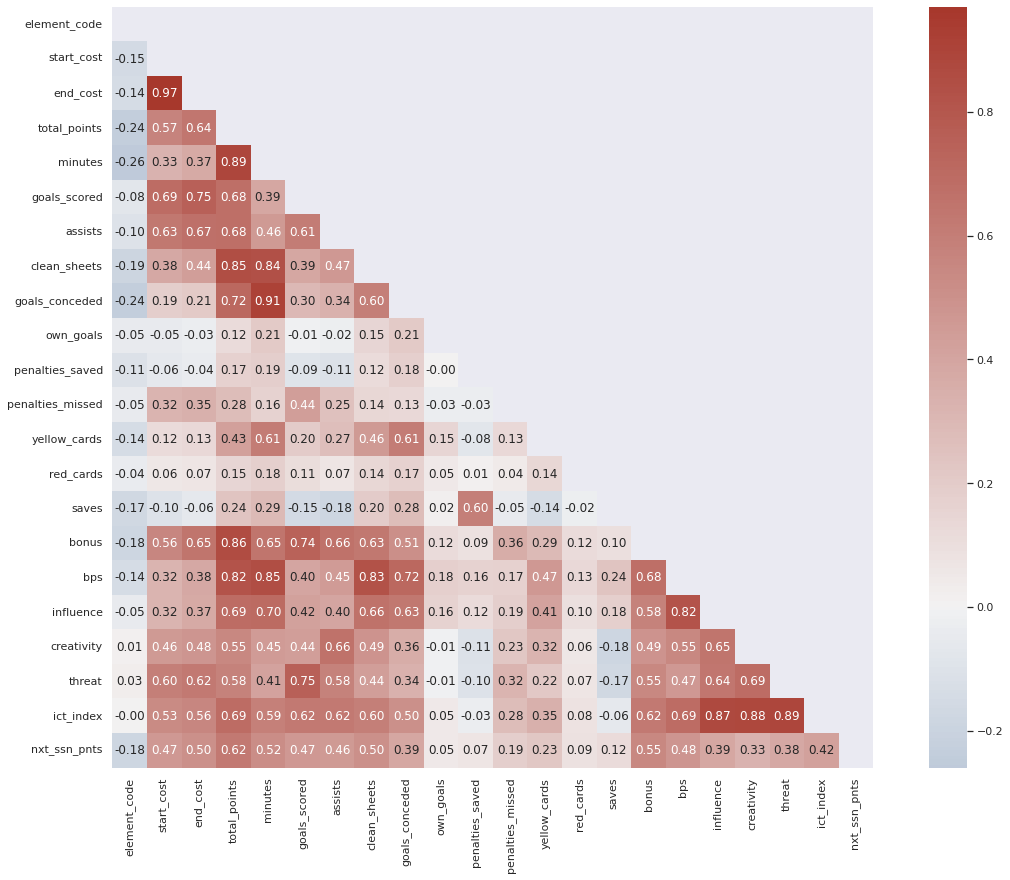

In [57]:
#Plotting the correlation between the numerical variables
corr_mat = model_df.corr().round(2)
mask = np.triu(np.ones_like(corr_mat, dtype=bool))
cmap = sns.diverging_palette(250, 15, s=75, l=40, n=9, center="light", as_cmap=True)
plt.figure(figsize=(20, 14))
sns.heatmap(corr_mat, mask=mask, center=0, annot=True, fmt='.2f', square=True, cmap=cmap)

plt.show();

In [58]:
# Dropping the columns that are not present in the stats dataset and the model that have high correlation to avoid
# an issue of multicolinearity
model_df = model_df.drop(columns = ['season_name', 'element_code', 'start_cost', 'end_cost', 'minutes', 
                                    'red_cards', 'penalties_missed', 'saves', 'bonus', 'bps'])

In [59]:
# Create dataset with only the required columns
X = model_df.iloc[:,1:-1]

# Create dataset with only the outcome variable
y = model_df.iloc[:,-1]

# Split data into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

# Create linear regression object
regr = LinearRegression()

# Train the model using the training sets
regr.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = regr.predict(X_test)

# Compute residuals
residuals = (y_test - y_pred)

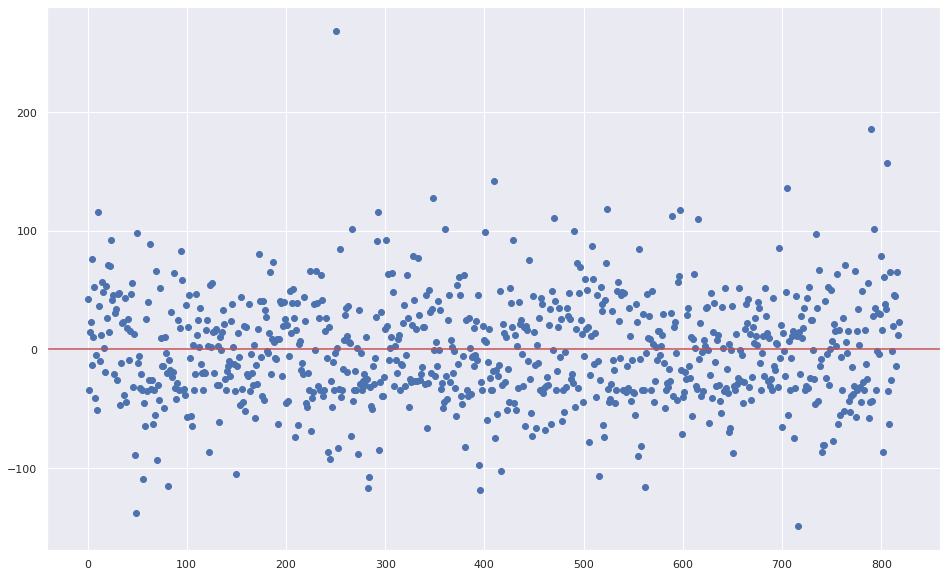

In [60]:
# Plot residuals
plt.scatter(range(len(residuals)),residuals)
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

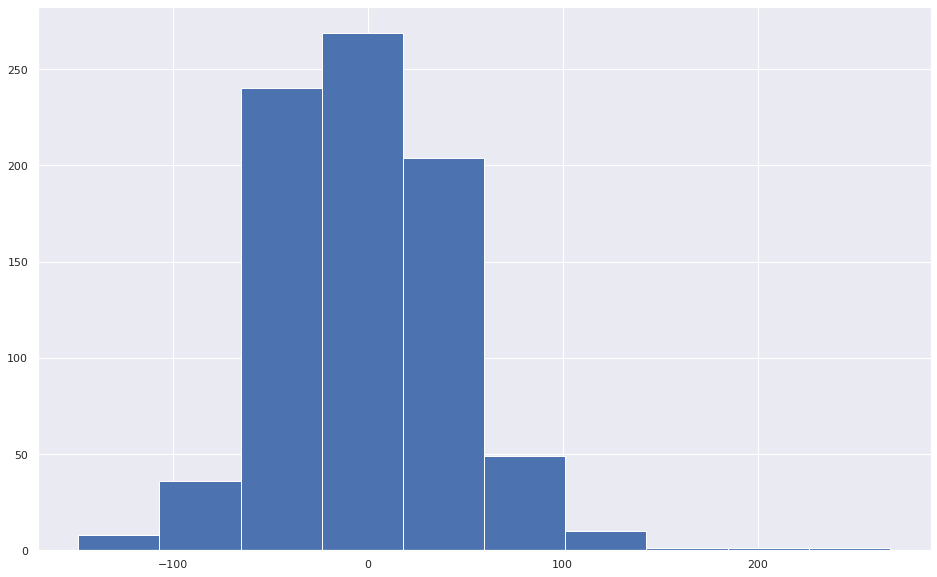

In [61]:
# Plot residuals
plt.hist(residuals)
plt.show()

In [62]:
# Check model metrics
mod = sm.OLS(y.astype(float), X.astype(float))
model = mod.fit()
model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                        Results: Ordinary least squares
================================================================================
Model:                  OLS              Adj. R-squared (uncentered): 0.719     
Dependent Variable:     nxt_ssn_pnts     AIC:                         17319.9363
Date:                   2022-08-31 15:19 BIC:                         17379.3499
No. Observations:       1638             Log-Likelihood:              -8649.0   
Df Model:               11               F-statistic:                 382.0     
Df Residuals:           1627             Prob (F-statistic):          0.00      
R-squared (uncentered): 0.721            Scale:                       2273.9    
-----------------------------------------------------------------------------------
                    Coef.      Std.Err.       t       P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
goals_scored         3.7620      0.5202     7.2317    0.0000      2.7416     4.7823
assists              3.9725      0.6168     6.4409    0.0000      2.7628     5.1823
clean_sheets         4.9148      0.3734    13.1608    0.0000      4.1823     5.6473
goals_conceded       1.0534      0.1022    10.3094    0.0000      0.8530     1.2538
own_goals           -2.9354      4.4036    -0.6666    0.5051    -11.5727     5.7019
penalties_saved      6.6641      5.2927     1.2591    0.2082     -3.7172    17.0453
yellow_cards        -0.9576      0.6203    -1.5439    0.1228     -2.1742     0.2590
influence            1.1734      0.5511     2.1293    0.0334      0.0925     2.2542
creativity           1.1625      0.5505     2.1117    0.0349      0.0827     2.2423
threat               1.1558      0.5467     2.1143    0.0346      0.0836     2.2281
ict_index          -11.7115      5.4940    -2.1317    0.0332    -22.4875    -0.9355
--------------------------------------------------------------------------------
Omnibus:                   108.855           Durbin-Watson:              2.164  
Prob(Omnibus):             0.000             Jarque-Bera (JB):           253.538
Skew:                      0.398             Prob(JB):                   0.000  
Kurtosis:                  4.755             Condition No.:              2927   
================================================================================
* The condition number is large (3e+03). This might indicate             strong
multicollinearity or other numerical problems.
"""

In [63]:
X_train.columns.values.tolist()

['goals_scored',
 'assists',
 'clean_sheets',
 'goals_conceded',
 'own_goals',
 'penalties_saved',
 'yellow_cards',
 'influence',
 'creativity',
 'threat',
 'ict_index']

In [64]:
# Extracting column names to use later to add predictions for next season
columns = X_train.columns.values.tolist()

In [65]:
# Predicting the outcome for next season
season_df['predict'] = regr.predict(season_df[columns])
season_df

,dreamteam_count,now_cost,points_per_game,selected_by_percent,total_points,transfers_in,transfers_out,minutes,goals_scored,assists,...,bps,influence,creativity,threat,ict_index,team,position,player_name,age_2022,predict
0,1,4.5,2.5,0.8,10,80974,205566,360,0,0,...,69,85.0,0.0,0.0,8.5,Arsenal,Goalkeeper,Bernd Leno,30.0,42.310798
1,0,9.6,3.1,1.2,44,742898,900060,1036,4,1,...,131,217.6,132.4,582.0,92.9,Arsenal,Forward,Pierre-Emerick Aubameyang,33.0,65.187076
2,1,4.2,2.3,0.4,48,66997,55154,1481,1,1,...,292,318.4,327.1,111.0,75.8,Arsenal,Defender,Cédric Soares,NaN,56.633292
3,1,8.1,3.0,3.1,90,1729889,1688857,1773,4,8,...,295,376.6,386.2,731.0,148.5,Arsenal,Forward,Alexandre Lacazette,31.0,111.294496
4,0,4.8,2.2,0.4,60,49300,97620,2327,1,2,...,334,395.4,522.9,262.0,118.2,Arsenal,Midfielder,Granit Xhaka,30.0,57.565152
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567,0,4.4,1.8,0.1,7,12082,11827,179,0,0,...,32,17.0,32.0,2.0,5.1,Wolves,Midfielder,Luke Cundle,20.0,37.765008
568,0,4.4,1.0,0.2,1,40835,37967,12,0,0,...,5,2.0,1.7,2.0,0.6,Wolves,Midfielder,Chem Campbell,19.0,33.821345
569,1,5.4,2.7,3.4,81,2119461,1898820,1811,5,1,...,288,322.2,268.3,481.0,106.7,Wolves,Forward,Hee-Chan Hwang,26.0,80.884851
570,0,4.4,1.5,0.0,6,696,558,360,0,0,...,52,87.0,4.5,28.0,12.0,Wolves,Defender,Toti António Gomes,NaN,34.844290


In [66]:
# Printing list of goalkeepers with the highest predicted points
query_goalkeeper = """
SELECT player_name, team, position, predict
FROM season_df
WHERE position = "Goalkeeper"
ORDER BY 4 DESC
LIMIT 3
"""

sqldf.run(query_goalkeeper)

,player_name,team,position,predict
0,Alisson Ramses Becker,Liverpool,Goalkeeper,122.698525
1,Lukasz Fabianski,West Ham,Goalkeeper,119.177394
2,Ederson Santana de Moraes,Man City,Goalkeeper,118.771903


In [67]:
# Printing list of defenders with the highest predicted points
query_defender = """
SELECT player_name, team, position, predict
FROM season_df
WHERE position = "Defender"
ORDER BY 4 DESC
LIMIT 10
"""

sqldf.run(query_defender)

,player_name,team,position,predict
0,Trent Alexander-Arnold,Liverpool,Defender,146.515861
1,Andrew Robertson,Liverpool,Defender,143.896534
2,Virgil van Dijk,Liverpool,Defender,135.477763
3,João Pedro Cavaco Cancelo,Man City,Defender,129.531106
4,Aymeric Laporte,Man City,Defender,124.143125
5,Joel Matip,Liverpool,Defender,120.596096
6,Rúben Santos Gato Alves Dias,Man City,Defender,110.753778
7,Matthew Cash,Aston Villa,Defender,108.497676
8,Conor Coady,Wolves,Defender,106.658025
9,Gabriel Magalhães,Arsenal,Defender,104.828036


In [68]:
# Printing list of midfielders with the highest predicted points
query_midfielder = """
SELECT player_name, team, position, predict
FROM season_df
WHERE position = "Midfielder"
ORDER BY 4 DESC
LIMIT 10
"""

sqldf.run(query_midfielder)

,player_name,team,position,predict
0,Heung-Min Son,Spurs,Midfielder,225.823858
1,Mohamed Salah,Liverpool,Midfielder,215.170812
2,Jarrod Bowen,West Ham,Midfielder,167.433999
3,Kevin De Bruyne,Man City,Midfielder,166.723382
4,Diogo Jota,Liverpool,Midfielder,153.909624
5,Sadio Mané,Liverpool,Midfielder,152.454910
6,Mason Mount,Chelsea,Midfielder,148.053334
7,James Maddison,Leicester,Midfielder,147.957073
8,Raheem Sterling,Man City,Midfielder,146.667723
9,James Ward-Prowse,Southampton,Midfielder,137.279273


In [69]:
# Printing list of forwards with the highest predicted points
query_forward = """
SELECT player_name, team, position, predict
FROM season_df
WHERE position = "Forward"
ORDER BY 4 DESC
LIMIT 10
"""

sqldf.run(query_forward)

,player_name,team,position,predict
0,Harry Kane,Spurs,Forward,175.181989
1,Cristiano Ronaldo dos Santos Aveiro,Man Utd,Forward,127.129637
2,Michail Antonio,West Ham,Forward,122.881505
3,Gabriel Fernando de Jesus,Man City,Forward,120.280071
4,Teemu Pukki,Norwich,Forward,116.322707
5,Jamie Vardy,Leicester,Forward,116.203911
6,Danny Ings,Aston Villa,Forward,114.619642
7,Danny Ings,Aston Villa,Forward,114.619642
8,Ivan Toney,Brentford,Forward,111.880995
9,Alexandre Lacazette,Arsenal,Forward,111.294496


The biggest variable with the highest coefficient is the ICT Index. Which makes sense since it is calculated using all the other metrics and is a good indicator of how well a player is performing.

The top defenders are predicted to, again, achieve higer points than the top forwards

The model is not meant to give accruate predication in regards to the exact points that a given player will get. It is to see who are the players that are predicted to end the season with relatively high points.

# Conclusion
The following are the recommended steps to follow for the 2022/23 season in order to achieve a relatively high score at the end of the season.
* Pick players who did well in the 2021/22 season as the data shows that players that a achieve a high score will most likely stay consistent and deliver a high number of points the following season.
* Avoid players who are spending their first sesaon in the Premier League. Unless, it is a high profile sigining.
* Stick to players in the age range of 23-31 as this is widely considered as the prime time for football players

In the first part of this project it was found that the ideal formation for season 2021/22 would have been a 4-5-1, as midfielders score the most points followed by defenders and then forwards. Having more defenders than forwards in the formation is also beneficial in that, in most cases, the cost of adding a forward to the draft is more expensive than a defender. This enables us to add more high profile defenders that have the potential to bring in more points.

Accoring to the model, the ideal formation to start the 2022/2023 season with is:
- Goalkeeper: 
              Alisson Ramses Becker (Liverpool)

- Defeneders: 
              Trent Alexander-Arnold (Liverpool)
              Andrew Robertson (Liverpool)
              Virgil van Dijk (Liverpool)
              João Pedro Cavaco Cancelo (Man City)
              
- Midfielders: 
              Heung-Min Son (Spurs)
              Mohamed Salah (Liverpool)
              Kevin De Bruyne (Man City)
              Diogo Jota (Liverpool)
              Jarrod Bowen (West Ham)
               
- Forward: 
              Harry Kane (Spurs)

Sadio Mané has left Liverpool during the summer transfer season (1). A change will need to be made and the player predicted to have the most points in midfield after Mane is Jarrod Bowen (West Ham).

Picking a team and sticking with it throughout the entire season might bring in a relatively highscore. However for one to excel at the game, there need to be weekly adjustments to the team depeneding on each playerss form and opponent.

# References
Premier League Fantasy Football (CW1)

(1) Premier League transfers: https://www.premierleague.com/news/2602004

# File Export

In [70]:
## Export historical stats dataset
# hist_df.to_csv(r'players_historical_data.csv', index = False)

## Exporting age dataset dataset
# age_df.to_csv(r'players_birth_date.csv', index = False)